# Customer Churn Analysis - Part 2: Feature Engineering
 
**Project**: Customer Churn Prediction  
**Notebook**: 02 - Feature Engineering & Preprocessing  
**Author**: Yunjae Jung 
**Date**: January 2026
 
## Objectives
- Load data from previous notebook
- Handle data quality issues
- Encode categorical variables
- Create engineered features
- Scale numerical features
- Prepare final dataset for modeling

## 1. Setup

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported")

✓ Libraries imported


# 2. Load Data

In [4]:
# Load data from previous notebook
DATA_DIR = Path('../data/processed')
df = pd.read_csv(DATA_DIR / 'data_after_eda.csv')

print(f"Dataset loaded: {df.shape}")
print(f"\nColumns ({len(df.columns)}):")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col}")

# Quick check
print("\nData Types:")
print(df.dtypes.value_counts())

print(f"\nMissing Values: {df.isnull().sum().sum()}")


Dataset loaded: (7043, 22)

Columns (22):
   1. customerID
   2. gender
   3. SeniorCitizen
   4. Partner
   5. Dependents
   6. tenure
   7. PhoneService
   8. MultipleLines
   9. InternetService
  10. OnlineSecurity
  11. OnlineBackup
  12. DeviceProtection
  13. TechSupport
  14. StreamingTV
  15. StreamingMovies
  16. Contract
  17. PaperlessBilling
  18. PaymentMethod
  19. MonthlyCharges
  20. TotalCharges
  21. Churn
  22. tenure_group

Data Types:
object     18
int64       2
float64     2
Name: count, dtype: int64

Missing Values: 11


## 3. Data Cleaning

### 3.1 Handle Missing Values

In [5]:
# Check for missing values in detail
missing_summary = pd.DataFrame({
    'Missing Count': df.isnull().sum(),
    'Percentage': (df.isnull().sum() / len(df)) * 100
}).sort_values('Missing Count', ascending=False)

print("Missing Values Summary:")
print("=" * 50)
print(missing_summary[missing_summary['Missing Count'] > 0])

if missing_summary['Missing Count'].sum() == 0:
    print("✓ No missing values to handle")

Missing Values Summary:
              Missing Count  Percentage
tenure_group             11    0.156183


### 3.2 Handle Data Type Issues

In [6]:
# Check for TotalCharges data type issue
print("Checking TotalCharges column...")
print(f"Current data type: {df['TotalCharges'].dtype}")

# Convert if needed (already done in notebook 01, but double-check)
if df['TotalCharges'].dtype == 'object':
    print("⚠️ TotalCharges is object type, converting to numeric...")
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    print(f"✓ Converted to: {df['TotalCharges'].dtype}")

# Fill any missing values
if df['TotalCharges'].isnull().sum() > 0:
    print(f"⚠️ Found {df['TotalCharges'].isnull().sum()} missing values in TotalCharges")
    df['TotalCharges'].fillna(0, inplace=True)
    print("✓ Filled missing values with 0")
else:
    print("✓ No missing values in TotalCharges")

Checking TotalCharges column...
Current data type: float64
✓ No missing values in TotalCharges


### 3.3 Remove Unnecessary Columns

In [7]:
# Drop customerID (not useful for modeling)
if 'customerID' in df.columns:
    df_clean = df.drop('customerID', axis=1)
    print("✓ Dropped customerID")
else:
    df_clean = df.copy()

# Drop tenure_group if it exists (we'll create it differently)
if 'tenure_group' in df_clean.columns:
    df_clean = df_clean.drop('tenure_group', axis=1)
    print("✓ Dropped tenure_group (will be recreated)")

print(f"\nCleaned dataset shape: {df_clean.shape}")


✓ Dropped customerID
✓ Dropped tenure_group (will be recreated)

Cleaned dataset shape: (7043, 20)


## 4. Feature Engineering

### 4.1 Create Binary Target Variable

In [8]:
# Convert Churn to binary
df_clean['Churn'] = (df_clean['Churn'] == 'Yes').astype(int)

print("Target Variable Distribution:")
print(df_clean['Churn'].value_counts())
print(f"\nChurn Rate: {df_clean['Churn'].mean()*100:.2f}%")


Target Variable Distribution:
Churn
0    5174
1    1869
Name: count, dtype: int64

Churn Rate: 26.54%


### 4.2 Create Tenure-Based Features

In [9]:
print("Creating tenure-based features...")

# 1. Tenure groups
df_clean['tenure_group'] = pd.cut(
    df_clean['tenure'],
    bins=[0, 12, 24, 48, 72],
    labels=['0-12', '12-24', '24-48', '48+']
)

# 2. Is new customer (first year)
df_clean['is_new_customer'] = (df_clean['tenure'] <= 12).astype(int)

# 3. Is long_term customer (>2 years)
df_clean['is_long_term'] = (df_clean['tenure'] > 24).astype(int)

# 4. Tenure bins (quarterly)
df_clean['tenure_bins'] = pd.cut(df_clean['tenure'], bins=8, labels=False)

print("✓ Created 4 tenure-based features")

Creating tenure-based features...
✓ Created 4 tenure-based features


### 4.3 Create Charge-Based Features

Creating charge-based features...
✓ Created 4 charge-based features


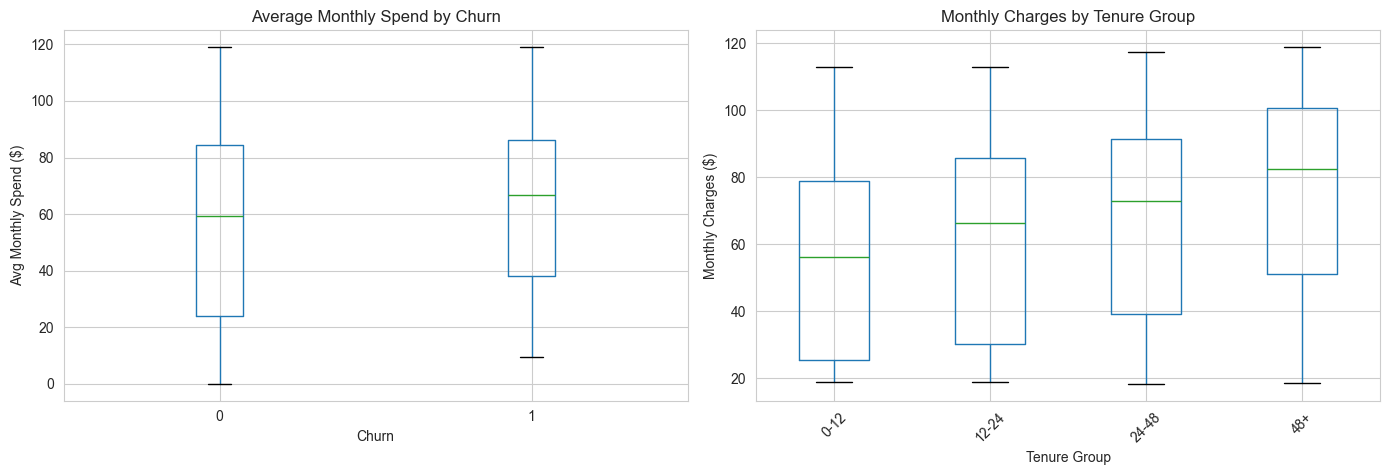

In [10]:
print("Creating charge-based features...")

# 1. Average monthly spend (total / tenure)
df_clean['avg_monthly_spend'] = df_clean['TotalCharges'] / (df_clean['tenure'] + 1)

# 2. Charge per tenure month
df_clean['charge_per_tenure'] = df_clean['MonthlyCharges'] / (df_clean['tenure'] + 1)

# 3. Price increase indicator (comparing monthly to average)
df_clean['price_increase'] = (
    df_clean['MonthlyCharges'] > df_clean['avg_monthly_spend']
).astype(int)

# 4. High monthly charge (above median)
monthly_median = df_clean['MonthlyCharges'].median()
df_clean['high_monthly_charge'] = (df_clean['MonthlyCharges'] > monthly_median).astype(int)

print("✓ Created 4 charge-based features")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Average monthly spend by churn
df_clean.boxplot(column='avg_monthly_spend', by='Churn', ax=axes[0])
axes[0].set_title('Average Monthly Spend by Churn')
axes[0].set_xlabel('Churn')
axes[0].set_ylabel('Avg Monthly Spend ($)')
plt.suptitle('')

# Monthly charges by tenure group
df_clean.boxplot(column='MonthlyCharges', by='tenure_group', ax=axes[1])
axes[1].set_title('Monthly Charges by Tenure Group')
axes[1].set_xlabel('Tenure Group')
axes[1].set_ylabel('Monthly Charges ($)')
axes[1].tick_params(axis='x', rotation=45)
plt.suptitle('')

plt.tight_layout()
plt.show()


### 4.4 Create Service-Based Features

In [11]:
print("Creating service-based features...")

# Service columns available in dataset
service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                'TechSupport', 'StreamingTV', 'StreamingMovies']

# Count of services used (count 'Yes' answers)
df_clean['total_services'] = 0
for col in service_cols:
    if col in df_clean.columns:
        df_clean['total_services'] += (df_clean[col] == 'Yes').astype(int)

# Has internet
df_clean['has_internet'] = (df_clean['InternetService'] != 'No').astype(int)

# Has phone
df_clean['has_phone'] = (df_clean['PhoneService'] == 'Yes').astype(int)

# Has tech support
if 'TechSupport' in df_clean.columns:
    df_clean['has_tech_support'] = (df_clean['TechSupport'] == 'Yes').astype(int)

# Has online security
if 'OnlineSecurity' in df_clean.columns:
    df_clean['has_online_security'] = (df_clean['OnlineSecurity'] == 'Yes').astype(int)

print("✓ Created service-based features")

# Analyze
print("\nService Usage vs Churn:")
print(df_clean.groupby('total_services')['Churn'].mean() * 100)


Creating service-based features...
✓ Created service-based features

Service Usage vs Churn:
total_services
0    21.406039
1    45.755694
2    35.818006
3    27.370304
4    22.300469
5    12.434326
6     5.281690
Name: Churn, dtype: float64


### 4.5 Create Contract & Payment Features

In [12]:
print("Creating contract/payment features...")

# Is month-to-month
df_clean['is_month_to_month'] = (df_clean['Contract'] == 'Month-to-month').astype(int)

# Has automatic payment
auto_payment_methods = ['Bank transfer (automatic)', 'Credit card (automatic)']
df_clean['has_auto_payment'] = df_clean['PaymentMethod'].isin(auto_payment_methods).astype(int)

# Paperless billing
df_clean['is_paperless'] = (df_clean['PaperlessBilling'] == 'Yes').astype(int)

print("✓ Created contract/payment features")


Creating contract/payment features...
✓ Created contract/payment features


### 4.6 Create Demographic Features

In [13]:
print("Creating demographic features...")

# Is senior citizen
df_clean['is_senior'] = df_clean['SeniorCitizen']

# Has family (partner or dependents)
has_partner = (df_clean['Partner'] == 'Yes').astype(int)
has_dependents = (df_clean['Dependents'] == 'Yes').astype(int)
df_clean['has_family'] = ((has_partner + has_dependents) > 0).astype(int)

# Is single with no dependents
df_clean['is_single_no_deps'] = (
    (df_clean['Partner'] == 'No') & 
    (df_clean['Dependents'] == 'No')
).astype(int)

print("✓ Created demographic features")

Creating demographic features...
✓ Created demographic features


## 5. Feature Summary

In [14]:
# List all engineered features
engineered_features = [
    'tenure_group', 'is_new_customer', 'is_long_term', 'tenure_bins',
    'avg_monthly_spend', 'charge_per_tenure', 'price_increase', 'high_monthly_charge',
    'total_services', 'has_internet', 'has_phone',
    'is_month_to_month', 'has_auto_payment', 'is_paperless',
    'has_family', 'is_single_no_deps'
]

print(f"Total Engineered Features: {len(engineered_features)}")
print("\nEngineered Features:")
for i, feat in enumerate(engineered_features, 1):
    if feat in df_clean.columns:
        print(f"{i:2d}. {feat}")


Total Engineered Features: 16

Engineered Features:
 1. tenure_group
 2. is_new_customer
 3. is_long_term
 4. tenure_bins
 5. avg_monthly_spend
 6. charge_per_tenure
 7. price_increase
 8. high_monthly_charge
 9. total_services
10. has_internet
11. has_phone
12. is_month_to_month
13. has_auto_payment
14. is_paperless
15. has_family
16. is_single_no_deps


## 6. Encode Categorical Variables

### 6.1 Identify Categorical Columns

In [15]:
# Separate features by type
categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove target if present
if 'Churn' in categorical_cols:
    categorical_cols.remove('Churn')

print(f"Categorical Columns to Encode ({len(categorical_cols)}):")
print(categorical_cols)

Categorical Columns to Encode (16):
['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_group']


### 6.2 Label Encoding for Binary Categories

In [16]:
# Binary categorical variables (Yes/No)
binary_cols = []
for col in categorical_cols:
    if df_clean[col].nunique() == 2:
        binary_cols.append(col)

print(f"\nBinary Columns ({len(binary_cols)}):")
print(binary_cols)

# Encode binary columns
for col in binary_cols:
    df_clean[col] = (df_clean[col] == 'Yes').astype(int)
    
print("✓ Binary columns encoded as 0/1")



Binary Columns (5):
['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
✓ Binary columns encoded as 0/1


### 6.3 One-Hot Encoding for Multi-Class Categories


In [17]:
# Multi-class categorical variables
multi_class_cols = [col for col in categorical_cols if col not in binary_cols]

print(f"\nMulti-class Columns ({len(multi_class_cols)}):")
for col in multi_class_cols:
    print(f"  {col}: {df_clean[col].nunique()} unique values")

# One-hot encode
df_encoded = pd.get_dummies(df_clean, columns=multi_class_cols, drop_first=False)

print(f"\n✓ One-hot encoding complete")
print(f"Dataset shape after encoding: {df_encoded.shape}")



Multi-class Columns (11):
  MultipleLines: 3 unique values
  InternetService: 3 unique values
  OnlineSecurity: 3 unique values
  OnlineBackup: 3 unique values
  DeviceProtection: 3 unique values
  TechSupport: 3 unique values
  StreamingTV: 3 unique values
  StreamingMovies: 3 unique values
  Contract: 3 unique values
  PaymentMethod: 4 unique values
  tenure_group: 4 unique values

✓ One-hot encoding complete
Dataset shape after encoding: (7043, 63)


## 7. Feature Scaling

### 7.1 Identify Numerical Features

In [18]:
# Numerical features to scale
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 
                 'avg_monthly_spend', 'charge_per_tenure']

# Only include columns that exist
numerical_cols = [col for col in numerical_cols if col in df_encoded.columns]

print(f"Numerical Columns to Scale ({len(numerical_cols)}):")
print(numerical_cols)


Numerical Columns to Scale (5):
['tenure', 'MonthlyCharges', 'TotalCharges', 'avg_monthly_spend', 'charge_per_tenure']


### 7.2 Visualize Before Scaling

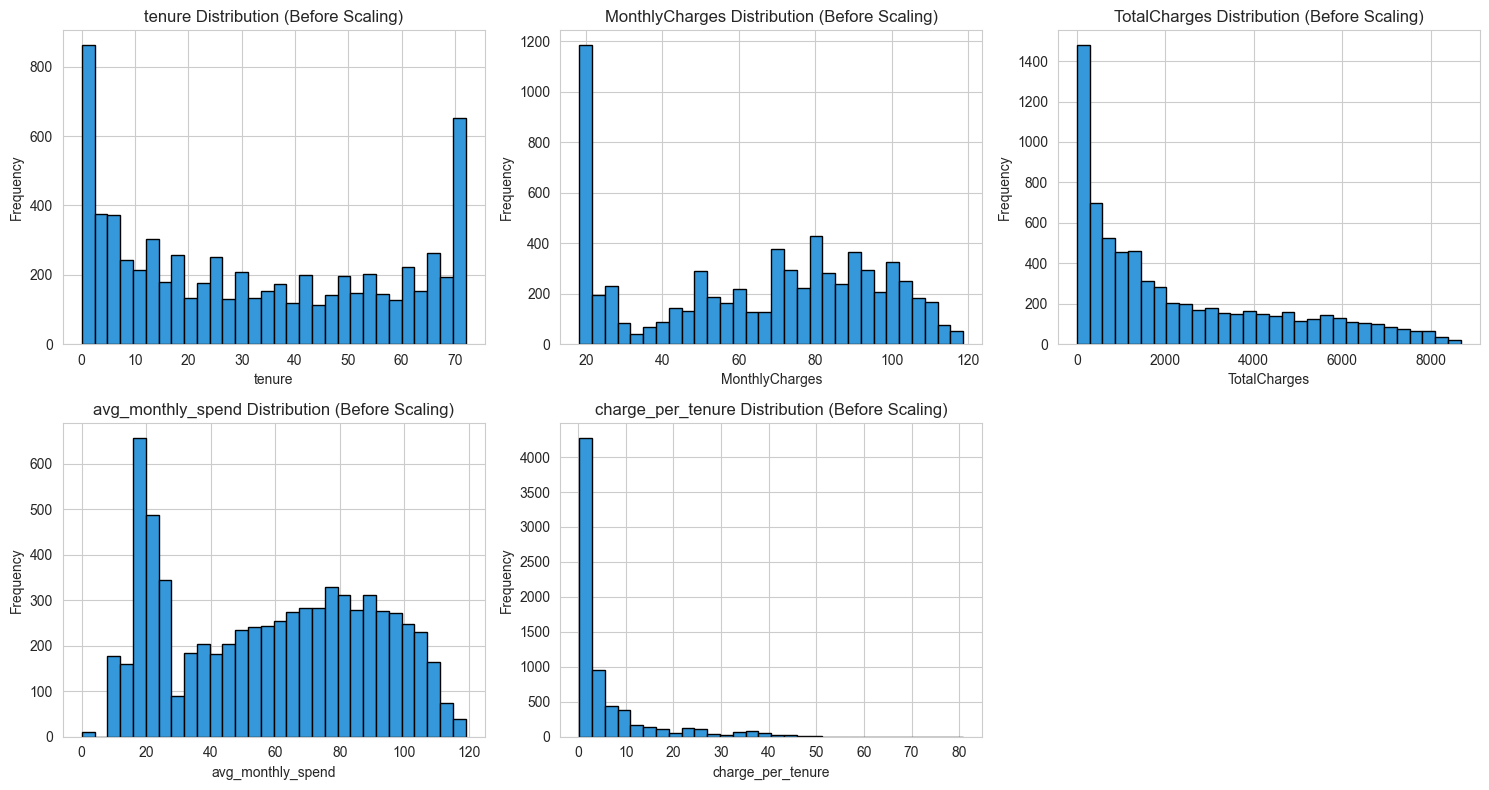

✓ Numerical features scaled using StandardScaler

Scaled Statistics:
         tenure  MonthlyCharges  TotalCharges  avg_monthly_spend  \
count  7043.000        7043.000      7043.000           7043.000   
mean     -0.000          -0.000        -0.000              0.000   
std       1.000           1.000         1.000              1.000   
min      -1.318          -1.546        -1.006             -1.929   
25%      -0.952          -0.973        -0.830             -1.078   
50%      -0.137           0.186        -0.391              0.064   
75%       0.921           0.834         0.665              0.845   
max       1.614           1.794         2.826              1.962   

       charge_per_tenure  
count           7043.000  
mean              -0.000  
std                1.000  
min               -0.631  
25%               -0.518  
50%               -0.424  
75%                0.020  
max                8.608  


In [19]:
# Plot distributions before scaling
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for i, col in enumerate(numerical_cols):
    if i < 6:
        df_encoded[col].hist(bins=30, ax=axes[i], color='#3498db', edgecolor='black')
        axes[i].set_title(f'{col} Distribution (Before Scaling)')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')

# Hide extra subplots
for i in range(len(numerical_cols), 6):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# %% [markdown]
# ### 7.3 Apply Scaling

# %%
# Create copy for scaling
df_scaled = df_encoded.copy()

# Initialize scaler
scaler = StandardScaler()

# Scale numerical features
df_scaled[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

print("✓ Numerical features scaled using StandardScaler")
print("\nScaled Statistics:")
print(df_scaled[numerical_cols].describe().round(3))


### 7.4 Visualize After Scaling

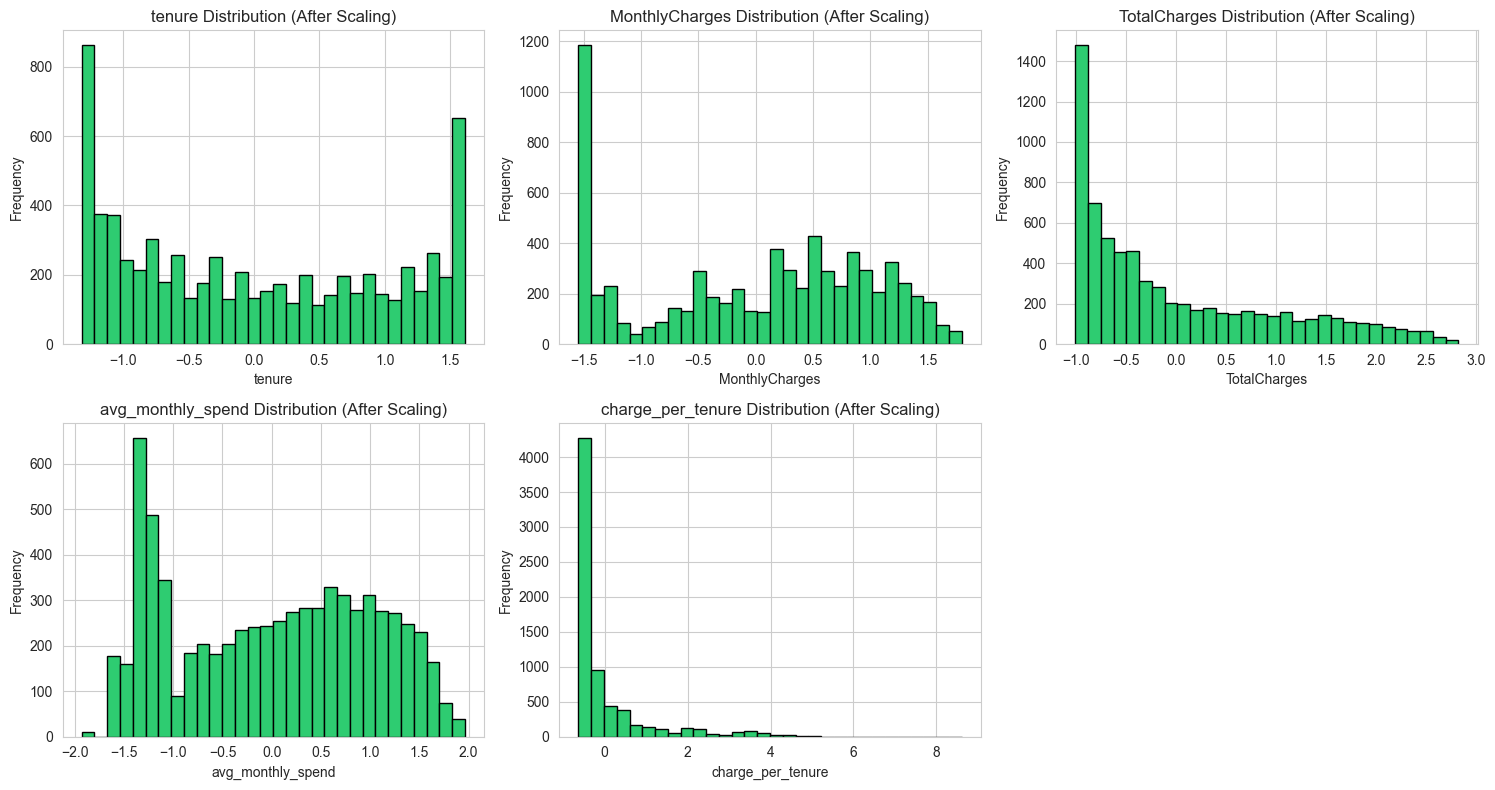

In [20]:
# Plot distributions after scaling
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for i, col in enumerate(numerical_cols):
    if i < 6:
        df_scaled[col].hist(bins=30, ax=axes[i], color='#2ecc71', edgecolor='black')
        axes[i].set_title(f'{col} Distribution (After Scaling)')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')

# Hide extra subplots
for i in range(len(numerical_cols), 6):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 8. Final Dataset Preparation

### 8.1 Verify Data Quality

In [21]:
print("Final Dataset Quality Check:")
print("=" * 50)
print(f"Shape: {df_scaled.shape}")
print(f"Missing values: {df_scaled.isnull().sum().sum()}")
print(f"Duplicates: {df_scaled.duplicated().sum()}")
print(f"Inf values: {np.isinf(df_scaled.select_dtypes(include=np.number)).sum().sum()}")

# Check data types
print("\nData Types:")
print(df_scaled.dtypes.value_counts())

Final Dataset Quality Check:
Shape: (7043, 63)
Missing values: 0
Duplicates: 41
Inf values: 0

Data Types:
bool       35
int64      23
float64     5
Name: count, dtype: int64


### 8.2 Feature Overview

In [22]:
# Separate features and target
X = df_scaled.drop('Churn', axis=1)
y = df_scaled['Churn']

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"\nTotal Features: {X.shape[1]}")

# Count feature types
original_features = len(df.columns) - 1  # excluding customerID
engineered_features_count = len([f for f in engineered_features if f in df_scaled.columns])
encoded_features_count = X.shape[1] - original_features

print(f"\nFeature Breakdown:")
print(f"  Original features: ~{original_features}")
print(f"  Engineered features: {engineered_features_count}")
print(f"  After encoding: {X.shape[1]}")

Features (X): (7043, 62)
Target (y): (7043,)

Total Features: 62

Feature Breakdown:
  Original features: ~21
  Engineered features: 15
  After encoding: 62


### 8.3 Class Balance Check

Target Distribution:
Churn
0    5174
1    1869
Name: count, dtype: int64

Class Balance:
  Class 0 (Retained): 5174 (73.46%)
  Class 1 (Churned): 1869 (26.54%)


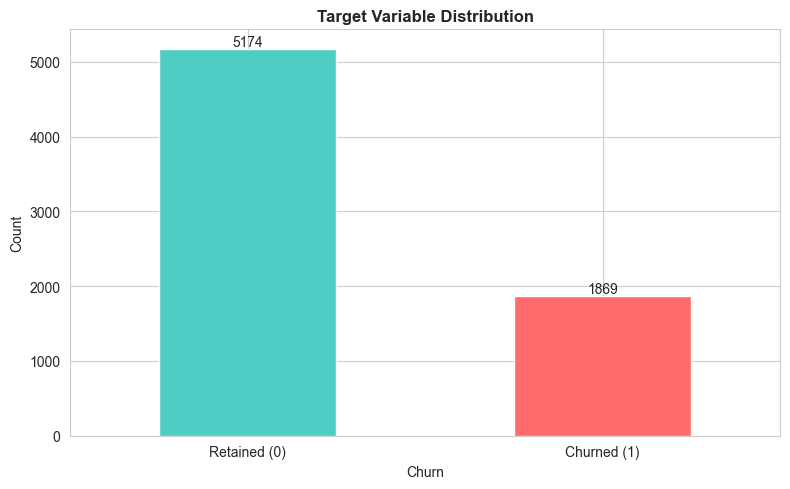


💡 Class imbalance present - will address in modeling with:
   • Stratified train-test split
   • Class weights in models
   • SMOTE (optional)


In [23]:
# Check target distribution
print("Target Distribution:")
print("=" * 50)
print(y.value_counts())
print(f"\nClass Balance:")
print(f"  Class 0 (Retained): {(y==0).sum()} ({(y==0).mean()*100:.2f}%)")
print(f"  Class 1 (Churned): {(y==1).sum()} ({(y==1).mean()*100:.2f}%)")

# Visualize
fig, ax = plt.subplots(figsize=(8, 5))
y.value_counts().plot(kind='bar', ax=ax, color=['#4ecdc4', '#ff6b6b'])
ax.set_title('Target Variable Distribution', fontsize=12, fontweight='bold')
ax.set_xlabel('Churn')
ax.set_ylabel('Count')
ax.set_xticklabels(['Retained (0)', 'Churned (1)'], rotation=0)
for container in ax.containers:
    ax.bar_label(container)
plt.tight_layout()
plt.show()

print("\n💡 Class imbalance present - will address in modeling with:")
print("   • Stratified train-test split")
print("   • Class weights in models")
print("   • SMOTE (optional)")

## 9. Save Processed Data

In [24]:
# Save final processed dataset
output_path = DATA_DIR / 'data_processed_final.csv'
df_scaled.to_csv(output_path, index=False)
print(f"✓ Final processed data saved to: {output_path}")

# Save feature names
feature_names_path = DATA_DIR / 'feature_names.txt'
with open(feature_names_path, 'w') as f:
    f.write("Feature Names (in order):\n")
    f.write("=" * 50 + "\n")
    for i, col in enumerate(X.columns, 1):
        f.write(f"{i:3d}. {col}\n")
        
print(f"✓ Feature names saved to: {feature_names_path}")

# Save scaler for deployment
import joblib
scaler_path = Path('../models')
scaler_path.mkdir(exist_ok=True)
joblib.dump(scaler, scaler_path / 'scaler.pkl')
print(f"✓ Scaler saved to: {scaler_path / 'scaler.pkl'}")


✓ Final processed data saved to: ../data/processed/data_processed_final.csv
✓ Feature names saved to: ../data/processed/feature_names.txt
✓ Scaler saved to: ../models/scaler.pkl


## 10. Feature Engineering Summary

In [25]:
print("=" * 80)
print("FEATURE ENGINEERING SUMMARY")
print("=" * 80)

print("\n✅ COMPLETED TASKS:")
print("  1. Data cleaning & type conversion")
print("  2. Created 16 engineered features")
print("  3. Encoded categorical variables")
print("  4. Scaled numerical features")
print("  5. Verified data quality")
print("  6. Saved processed data & artifacts")

print("\n📊 FINAL DATASET:")
print(f"  Total samples: {df_scaled.shape[0]:,}")
print(f"  Total features: {X.shape[1]}")
print(f"  Churn rate: {y.mean()*100:.2f}%")

print("\n🎯 KEY ENGINEERED FEATURES:")
print("  • Tenure-based: is_new_customer, is_long_term, tenure_bins")
print("  • Charge-based: avg_monthly_spend, price_increase, high_monthly_charge")
print("  • Service-based: total_services, has_internet, has_tech_support")
print("  • Contract-based: is_month_to_month, has_auto_payment")
print("  • Demographic: has_family, is_single_no_deps")

print("\n" + "=" * 80)

FEATURE ENGINEERING SUMMARY

✅ COMPLETED TASKS:
  1. Data cleaning & type conversion
  2. Created 16 engineered features
  3. Encoded categorical variables
  4. Scaled numerical features
  5. Verified data quality
  6. Saved processed data & artifacts

📊 FINAL DATASET:
  Total samples: 7,043
  Total features: 62
  Churn rate: 26.54%

🎯 KEY ENGINEERED FEATURES:
  • Tenure-based: is_new_customer, is_long_term, tenure_bins
  • Charge-based: avg_monthly_spend, price_increase, high_monthly_charge
  • Service-based: total_services, has_internet, has_tech_support
  • Contract-based: is_month_to_month, has_auto_payment
  • Demographic: has_family, is_single_no_deps

